In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
plt.rcParams.update({'figure.dpi':150})
import sys
sys.path.append("/home/msdos/DESI-QA/")

def angle_between(c, p1, p2):
    # p1, p2 are points (x,c); c is center (xc, yc)
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

## 1. Before xy tests

Before you run xy, you need your system calibration
- _pix2mm_:   &nbsp; conversion rate form fiducial measurement
- _center_:   &nbsp; center of the Theta ARC for a given positioner
- _R1_: &emsp;&nbsp; size of theta arm (in mm)
- _R2_: &emsp;&nbsp; size of phi arm (in mm) 

In [24]:
# calibration
pix2mm = 0.03536752443853155 # pix calibrated 23 May

can_num = '4852'

# Typical pix value for center: 1982.5063188335544, 887.8498175427958
center = {can_num:[69.96433, 31.51567]} # center of theta arc
# This is where stuff gets updated??? - SM - yeah

R1 = {can_num: 2.9467126} # R theta
R2 = {can_num: 3.0691875} # R phi

RPositioner = R1[can_num]+R2[can_num]

hardstop_ang = 163.01813  # hardstop angle is the angle btw theta_center and phi_center(parked_theta), 

buffer = 0.5 # buffer in mm between the edge of the positioner patrol radius, and the max allowable move

## Targets

In [25]:
# targets:
# defining targets in mm in the center of positioner coordinates
def create_target(grid, filename=None, plot=True, overwrite=False, verbose=False,zig=False,zag=False,flip_y=False,flip_x=False):
    """
    Usage: create_target(np.linspace(-6.0, 6.0, 8), 
                        filename='../movetables/<NAME>', *)
    
    grid (list, np array): 
        e.g. np.linspace(-5.5, 5.5, 6) creates a 32 points xy
    """
    xtgt = []
    ytgt = []
    if zig:
        if zag:
            y_index,x_index = Zig(grid,grid)
        else:
            x_index,y_index = Zig(grid,grid)
        for i in range(len(grid)*len(grid)):
            _dist = np.hypot(grid[x_index[i]],grid[y_index[i]])
            if _dist > RPositioner-buffer:
                if verbose: print(f"out of reach: {i:+.2f}, {j:+.2f}, {_dist:.2f}")
            else:
                x_val = grid[x_index[i]]
                y_val = grid[y_index[i]]
                if flip_y:
                    y_val = -y_val
                if flip_x:
                    x_val = -x_val
                xtgt.append(x_val)
                ytgt.append(y_val)
        
    else:
        for i,j in list(itertools.product(grid, grid)):
            _dist = np.hypot(i,j)
            if _dist > RPositioner-buffer:
                if verbose: print(f"out of reach: {i:+.2f}, {j:+.2f}, {_dist:.2f}")
            else:
                xtgt.append(i)
                ytgt.append(j)
            
    

    print(f"Produced {len(xtgt)} targets")
    
    if plot:
        plt.figure(dpi=100)
        plt.plot(xtgt, ytgt, '+', ms=8)
        plt.plot(0,0, 'ro', zorder=0, alpha=0.4)
        plt.gca().set_aspect('equal')
        
    if filename is None:
        print("filename is None")
    elif os.path.isfile(filename) and (not overwrite):    
        print(f"\nERROR: File {filename} exists")
    else: 
        np.savetxt(filename, np.c_[xtgt, ytgt])
    
    return xtgt, ytgt


# counting function for creating the x and y indices of the zig-zag pattern
def Zig(x_arr,y_arr):
    
    x_index = []
    y_index = []

    last = 0
    for i in range(len(x_arr)):
        iters=0
        while iters <= last:
            x_index.append(iters)
            iters+=1
        last+=1

    last = len(x_arr)-1
    iters = 0
    for j in range(len(x_arr)):
        iters=j+1
        while iters <= last:
            x_index.append(iters)
            iters+=1

    last=0
    for k in range(len(y_arr)):
        last=0
        iters=k
        while iters>=last:
            y_index.append(iters)
            iters-=1

    last=len(y_arr)-1
    for k in range(len(y_arr)):
        iters=k+1
        while iters<=last:
            y_index.append(last)
            last-=1
        last=len(y_arr)-1
        
    return x_index,y_index

### Kernel for Testing the zig function - ignore

If you want to do tests, redefine the linspace array in test() call 

(-3.083333333333333, -4.316666666666666)

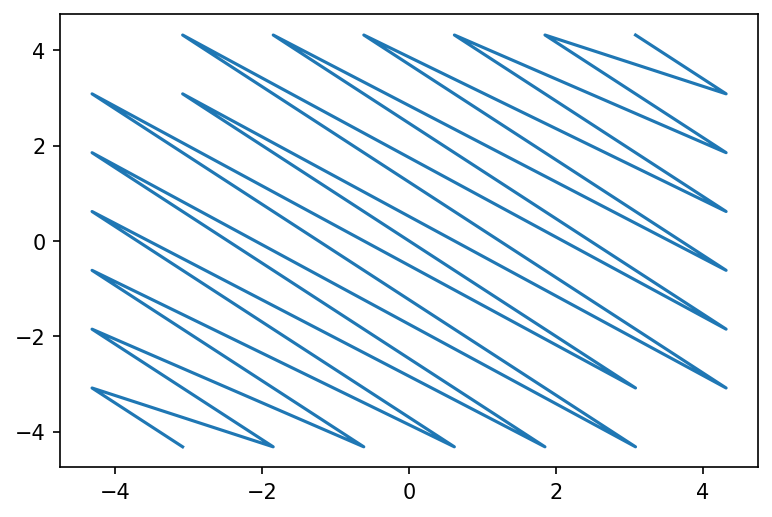

In [26]:
def test(grid,zig=False,zag=False,verbose=False,flip_y=False,flip_x=False): # function for testing the zig-zag sequence - redundant for now

    if zig:
        if zag:
            y_index,x_index = Zig(grid,grid)
        else:
            x_index,y_index = Zig(grid,grid)
        xtgt = []
        ytgt = []
        ite = 0
        for i in range(len(grid)*len(grid)):
            _dist = np.hypot(grid[x_index[i]],grid[y_index[i]])
            if _dist > RPositioner-buffer:
                if verbose: print(f"out of reach: {i:+.2f}, {j:+.2f}, {_dist:.2f}")
            else:
                x_val = grid[x_index[i]]
                y_val = grid[y_index[i]]
                if flip_y:
                    y_val = -y_val
                if flip_x:
                    x_val = -x_val
                xtgt.append(x_val)
                ytgt.append(y_val)
    else:
        xtgt = []
        ytgt = []
        for i,j in list(itertools.product(grid, grid)):
            _dist = np.hypot(i,j)
            if _dist > RPositioner-buffer:
                if verbose: print(f"out of reach: {i:+.2f}, {j:+.2f}, {_dist:.2f}")
            else:
                xtgt.append(i)
                ytgt.append(j)
    return xtgt,ytgt

xtest,ytest = test(np.linspace(-5.55,5.55,10),zig=True,zag=True,flip_y=False,flip_x=False)

plt.plot(xtest,ytest)

xtest[0],ytest[0]

### Create and view the movetable

Produced 60 targets


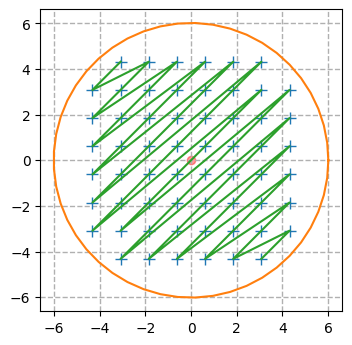

In [32]:
x0,y0 = create_target(np.linspace(-5.55,5.55,10), filename='../movetables/xy_60_zag_flipy.txt',zig=True,zag=True,flip_x=False,flip_y=True)
plt.grid(lw=1, ls='--')
thpat = np.linspace(0, np.pi*2)
xpat, ypat = RPositioner*np.cos(thpat), RPositioner*np.sin(thpat)
plt.plot(xpat, ypat)
plt.plot(x0,y0)

Produced 16 targets

ERROR: File ../movetables/XY_16.txt exists


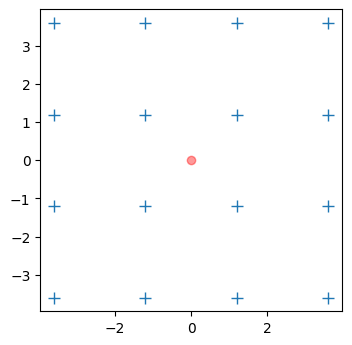

In [5]:
_ = create_target(np.linspace(-6, 6, 6), filename='../movetables/XY_16.txt')

In [6]:
def transform(H,R_theta,R_phi,x,y): 
    """
    function to output theta and phi angles based on coordinates relative to center 
    """
    
    if x==0 and y==0:
        theta = 0
        phi = 0
    
    H = H*np.pi/180
    d = np.sqrt(x**2 + y**2)
    a = d*np.cos(H)
    b = d*np.sin(H)
    r = np.sqrt((x-a)**2 + (y-b)**2)
    alpha = 2*np.arcsin(r/(2*d))
    #print(alpha*180/np.pi)
    phi = np.arccos((R_phi**2 + R_theta**2 - d**2)/(2*R_theta*R_phi))
    d_theta = np.arcsin(R_theta*np.sin(phi)/d)

    
    if abs(H) > np.pi/2:
        if y>(b/a)*x:
            theta = alpha + d_theta
        if y<=(b/a)*x:
            theta = ((2*np.pi)-alpha) + d_theta
    else:
        if y>(b/a)*x:
            theta = ((2*np.pi)-alpha) + d_theta
        if y<=(b/a)*x:
            theta = alpha + d_theta 
    
    theta = theta*180/np.pi
    phi = phi*180/np.pi
    
    if theta>360:
        theta = theta - 360
    
    return theta,phi


In [7]:
np.isclose

<function numpy.isclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)>

In [8]:
def prepare2xy(xc,yc, x0,y0, x1,y1):
    """
    Simple coord change y-> -y
    for consistency in fiposcontroller
    """
    u0, v0 = x0-xc, y0-yc
    u1, v1 = x1-xc, y1-yc
    return u0, -v0, u1, -v1


#version of the function to give moves
def calc_moves(H,R_theta,R_phi, xc, yc, x0,y0,x,y): #function to output moves in theta and phi 
    """
    # ALWAYS IN mm, ALWAYS IN THE POSITIONERS REFERENCE
    BEFORE YOU PASS: 
     - Change the center of coordinate system to the center of theta arc
     - Invert the y axis, keep the x axis intact
     - 
    TODO: Round the number for close to Zero!
    """
    assert np.hypot(x -xc,y-yc)<=R_theta+R_phi, f'out of reach move {np.hypot(x,y)}'
    assert np.hypot(x0-xc,y0-yc)<=R_theta+R_phi, f'out of reach move {np.hypot(x0,y0)<=R_theta+R_phi}'
    
    x0,y0,x,y = prepare2xy(xc, yc, x0,y0,x,y)
    
    #where you are
    theta0,phi0 = transform(H,R_theta,R_phi,x0,y0)
    #where you want to be 
    theta,phi = transform(H,R_theta,R_phi,x,y)
    #difference
    delta_theta = theta-theta0
    delta_phi = phi-phi0
    #logic
    if delta_theta >= 0:
        theta_cw = abs(delta_theta)
        theta_ccw = 0
    elif delta_theta < 0:
        theta_cw = 0
        theta_ccw = abs(delta_theta)
    if delta_phi >= 0:
        phi_cw = abs(delta_phi)
        phi_ccw = 0
    elif delta_phi < 0:
        phi_cw = abs(delta_phi)
        phi_ccw = 0
    
    theta_cw
    return theta_cw,theta_ccw,phi_cw,phi_ccw

In [9]:
def xy2move(calc):
    """
    Interface between calc_moves and command 
    to fiposcontroller
    Input:
    calc: (list):
        output from calc_moves with
        [th_cw, th_ccw, ph_cw, ph_ccw]
    Returns:
        list with direction(str), motor(str), angle (float)
    """
    _dir = ['cw','ccw']
    ith = [0 if calc[0] > calc[1] else 1][0]
    iph = [0 if calc[2] > calc[3] else 1][0]
    theta = calc[ith]
    phi  = calc[iph+2]
    row = []
    if abs(theta) >=1e-2:
        row.append([_dir[ith], 'theta', theta])
    if abs(phi) >=1e-2:
        row.append([_dir[iph], 'phi', phi])
    return row
    

In [10]:
xtst

NameError: name 'xtst' is not defined

In [45]:
xy2move(calc_moves(167, 3, 3, 
                   0,0,
                         xtst[i-1], -ytst[i-1], 
                         xtst[i],   -ytst[i]))

AssertionError: out of reach move 102.80377056446258

## testing 

In [11]:
# Solving the small number! 
# do not return 
aa = np.linspace(-90, 300, 6) #cw passing 360
xtst, ytst = 3*np.cos(np.deg2rad(aa)), 3*np.sin(np.deg2rad(aa))

"""
(116.66666666666646, 0, 0.0, 0)
(0, 243.33333333333312, 1.4210854715202004e-14, 0)
(116.66666666666667, 0, 2.842170943040401e-14, 0)
"""

'\n(116.66666666666646, 0, 0.0, 0)\n(0, 243.33333333333312, 1.4210854715202004e-14, 0)\n(116.66666666666667, 0, 2.842170943040401e-14, 0)\n'

In [12]:
aa = np.linspace(-180, -90, 3)
xc,yc= 5,100
R1, R2 = 3,3 

['ccw', 'theta', 77.99999999999974]
['ccw', 'theta', 78.00000000000043]
['ccw', 'theta', 77.9999999999999]
['ccw', 'theta', 77.99999999999999]
['cw', 'theta', 282.0]


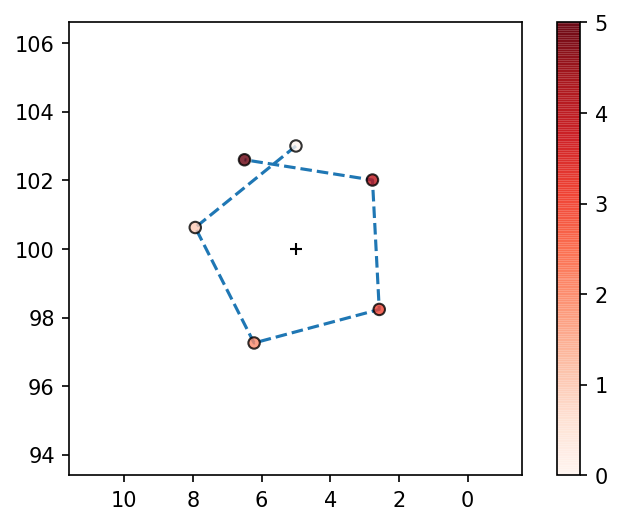

In [13]:
# this should returns 2 cw moves:

aa = -np.linspace(-90, 300, 6)
aa[:-1] - aa[1:]


xtst, ytst = 3*np.cos(np.deg2rad(aa)) +5, 3*np.sin(np.deg2rad(aa)) +100

plt.plot(xtst, ytst, '--',  ms=10)
plt.scatter(xtst, ytst, c=np.arange(len(xtst)), cmap='Reds', edgecolors='k',
            s=30, alpha=.8, zorder=24)
plt.colorbar()

for i, xy in enumerate(np.c_[xtst[:], ytst[:]]):
    ix, iy = xy
    
    if i>0:
        calc = calc_moves(167, R1, R2, 
                          xc, yc,
                         xtst[i-1], ytst[i-1], 
                         xtst[i],   ytst[i])

        row = xy2move(calc)
        for j in row:
            print(j)

plt.plot(xc,yc, 'k+')        
plt.xlim( xc+1.1*(R1+R2), xc-1.1*(R1+R2) )
plt.ylim( yc-1.1*(R1+R2), yc+1.1*(R1+R2) ) 
plt.gca().set_aspect('equal')

In [14]:
# table for test
row[0]


['cw', 'theta', 282.0]

In [16]:
x_here, y_here = None,None
if _here is None:
    x_here, y_here = get_currpos()

ix, iy = from_spotfinder()
calc = calc_moves(167, 3, 3, 
                  xc, yc,
                 xtst[i-1], ytst[i-1], 
                 xtst[i],   ytst[i])


rows = xy2move(calc)
send_move_from_rows
has_correction


NameError: name '_here' is not defined

# Testing

In [17]:

for i in range(1000000):
    x0,y0, x1,y1 = np.random.random_sample(4)*12
    if np.hypot(x,y)<6:
        try:
            calc_moves(hardstop_ang, R1['4852'], R2['4852'], x0,y0,x1,y1)

        except Exception as err:
            print(err, f"{x,y}")
    else:
        pass
#         print("Out of reach", {x0,y0,x1,y1})


NameError: name 'x' is not defined

In [10]:
calc_moves(hardstop_ang, R1['4852'], R2['4852'], 0.00, 0.00, 0, 6)

TypeError: calc_moves() missing 2 required positional arguments: 'x' and 'y'

In [167]:
calc_moves(hardstop_ang, R1['4852'], R2['4852'], -1, -2, -1, -2)


(0.0, 0, 0.0, 0)

In [261]:
calc_moves(hardstop_ang, R1['4852'], R2['4852'], 0.00, 0.1, 1, 1)
calc_moves(hardstop_ang, R1['4852'], R2['4852'], 0.01, 0.00, 0, 6)
calc_moves(hardstop_ang, R1['4852'], R2['4852'], 0.00, 0.01, 0, 6)
calc_moves(hardstop_ang, R1['4852'], R2['4852'], 0.01, 0.01, 0, 6)

TypeError: calc_moves() missing 2 required positional arguments: 'x' and 'y'

-6.0 0.0
0.0 -6.0
-5.63815572471545 -2.0521208599540133


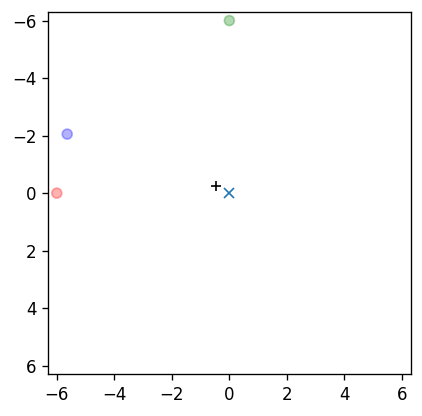

In [82]:
x = [-6, 0, 6*np.cos(np.deg2rad(-160))]
y = [0, -6, 6*np.sin(np.deg2rad(-160))]
plt.xlim(-6.3,6.3)
plt.ylim(6.3, -6.3)
plt.plot(0,0,'x')
plt.scatter(x,y, c=['r','g','b'], alpha=0.3)
plt.plot(-0.47012629971222, -0.2569017633446613, 'k+')
for i in np.c_[x,y]:
    print(i[0], i[1])
plt.gca().set_aspect('equal')

In [88]:
mvargs = ['cw', 'cruise', 'phi', 23]
mvargs = [str(i) for i in mvargs] 
" ".join(mvargs)

'cw cruise phi 23'

# Correction moves

In [264]:
# TODO: remove hardcoded stuff here
pix2mm = 0.035337
# todo, pass this as dictionary per positioner
dev_bb = {'can22': ['4852']}
posid = '4852'
hardstop_ang = {"4852": 166.270588} # in deg
R1 = {"4852": 3.0747} # R theta
R2 = {"4852": 2.9625} # R phi
center = {"4852":[ 69.60399862271909, 31.40032983828514]}

pos_speed = {"4852":{"cruise": 33, "spinramp": 12, }}
def setplot(xc=0, yc=0, rmax=6.0):
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')

In [2]:
import xylib 
import importlib
importlib.reload(xylib)

<module 'xylib' from '/home/msdos/DESI-QA/xylib.py'>

In [355]:
h, r1, r2 = -166.27, 3, 3

pl = (-6, 0) 
pr = ( 6, 0)
pu = ( 0,-6)
pd = ( 0, 6)
pld = (-6*np.cos(np.pi/4),  6*np.sin(np.pi/4) ) # 'point left down' for the observer
plu = (-6*np.cos(np.pi/4), -6*np.sin(np.pi/4) )
prd = ( 6*np.cos(np.pi/4),  6*np.sin(np.pi/4) )
pru = ( 6*np.cos(np.pi/4), -6*np.sin(np.pi/4) )


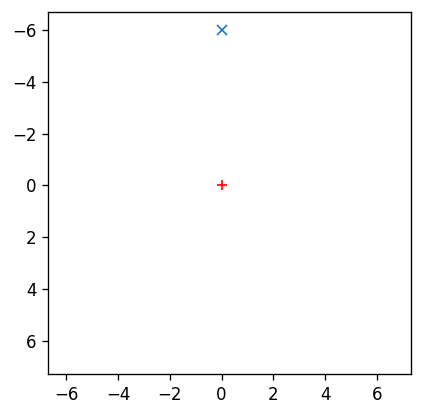

In [356]:
plt.plot(*pu,'x')
setplot(rmax=7)

In [358]:
truth = {(pl, pu):  [["cw", 'theta',  90.]],
         (pl, pd):  [["cw", 'theta', 270.]],
         (pl, pr):  [["cw", 'theta', 180.]],
         (pu, pd):  [["cw", 'theta', 180.]],
         (pu, pl):  [["ccw",'theta',  90.]],
         (pu, pld): [["cw", 'theta', 225.]],
         (pl, pld): [["cw", 'theta', 315.]],
         (pld, pl): [["ccw", 'theta', 315.]],
        }

for p0,pf in list(truth.keys()):
    move =  xylib.calc_movetables(h, r1, r2, *p0, *pf )
    print(move, end=" \t")
    print(truth[(p0,pf)])
    assert move == truth[(p0,pf)], "Error!"

[['ccw', 'theta', 270.0]] 	[['cw', 'theta', 90.0]]


AssertionError: Error!

## phi

In [359]:
importlib.reload(xylib)

<module 'xylib' from '/home/msdos/DESI-QA/xylib.py'>

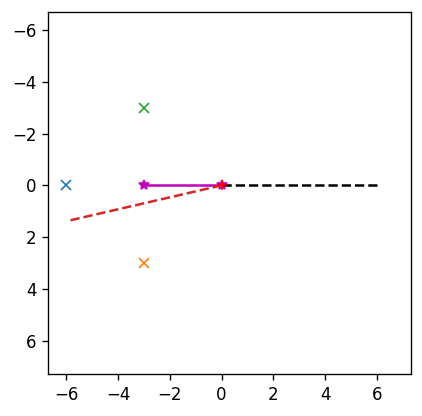

In [360]:
ql = (-(r1+r2), 0) 
qr = (       0, 0)
qu =  ( -3  , -3)
qd = ( -r1    , r2)
# qld = (-3*np.cos(np.pi/4),  3*np.sin(np.pi/4) ) # 'point left down' in phi for the observer
# qlu = (-3*np.cos(np.pi/4), -3*np.sin(np.pi/4) )
# qrd = ( 3*np.cos(np.pi/4),  3*np.sin(np.pi/4) )
# qru = ( 3*np.cos(np.pi/4), -3*np.sin(np.pi/4) )
plt.plot([-3,0],[0,0], 'm-*', zorder=0)
plt.plot(*ql, 'x')
plt.plot(*qd, 'x')
plt.plot(*qu, 'x')
plt.plot([0, 6*np.cos(np.radians(167))],[ 0 , 6*np.sin(np.radians(167))], '--')
plt.plot([0, 6*np.cos(0)],[ 0 , 6*np.sin(0)], 'k--')

setplot(rmax=7)

In [361]:
inv = lambda y: -y
xylib.transform(h, r1, r2, -3, inv(-3) )

(103.73000000000005, 90.0)

In [362]:
truth_phi = {
         (ql, qd):  [["ccw", 'phi',   90.]],
         (ql, qu):  [["cw", 'theta',  90.], ["ccw", "phi", 90.]],
#          (pl, pr):  [["cw", 'theta', 180.]],
#          (pu, pd):  [["cw", 'theta', 180.]],
#          (pu, pl):  [["ccw",'theta',  90.]],
#          (pu, pld): [["cw", 'theta', 225.]],
#          (pl, pld): [["cw", 'theta', 315.]],
#          (pld, pl): [["ccw", 'theta', 315.]],
        }

In [363]:
importlib.reload(xylib)

for p0,pf in list(truth_phi.keys()):
    move =  xylib.calc_movetables( h, r1, r2, *p0, *pf )
    print(move, end=" \t")
    print(truth_phi[(p0,pf)])
    assert move == truth_phi[(p0,pf)], "Error!"

[['ccw', 'phi', 90.0]] 	[['ccw', 'phi', 90.0]]
[['cw', 'theta', 90.0], ['ccw', 'phi', 90.0]] 	[['cw', 'theta', 90.0], ['ccw', 'phi', 90.0]]


In [241]:
xylib.calc_movetables(h,r1,r2, *ql, *qu),# xylib.calc_movetables(h,r1,r2, *ql, *qd)

([['cw', 'phi', 90.0]],)

In [385]:
xylib.transform(-2.9019692098269734,3.0747,2.9625, -5.790017455871087, -1.7317921210575378)
"""
# arg = (R_phi**2 + R_theta**2 - d**2)/(2*R_theta*R_phi),  'arg': -1.0041510550361463,
# arg(2.9625,3.0747, 6.043459778127828 )

{'H': -2.9019692098269734,
 'R_phi': 2.9625,
 'R_theta': 3.0747,
 'a': -5.870782506244238,
 'alpha': 0.051007125340773084,
 'arg': -1.0041510550361463,
 'b': -1.4343356839406483,
 'd': 6.043459778127828,
 'r': 0.3082260945216216,
 'x': -5.790017455871087,
 'y': -1.7317921210575378}

"""
arg = lambda R_phi, R_theta, d : (R_phi**2 + R_theta**2 - d**2)/(2*R_theta*R_phi)
dd =np.hypot(-3.0747, 2.96)

dd, 2.9625 + 3.0747, arg(2.9625,3.0747, dd ), 

(4.267947995231432, 6.0372, 0.0008127443808108872)

In [ ]:
arg = lambda R_phi, R_theta, d : (R_phi**2 + R_theta**2 - d**2)/(2*R_theta*R_phi)


170.3951066708586

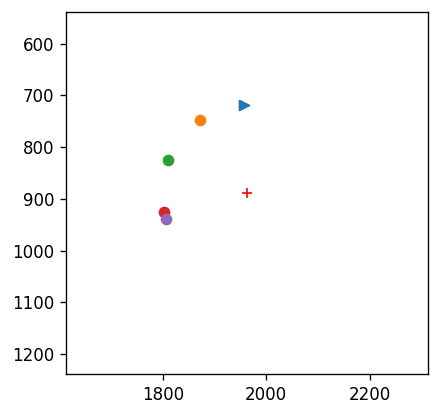

In [279]:
xc, yc =       (1962.7200844078186, 888.5963674982352)
xopen, yopen = 1956.1128021215288,718.329411813456
angle_between((xc, yc), (xc+170, yc), (1996.5172880873918,1057.1686569922542) )
# plt.scatter(xc+170 , yc)
plt.scatter(xopen, yopen, marker='>')
plt.scatter(1872.824300557093, 747.626658076772)
plt.scatter(1810.6578863198274, 825.4254550065804)
plt.scatter(1802.631135461088, 925.1099589272549)
plt.scatter(1806.3691302401744 , 939.2682919370402)
setplot(xc=xc, yc=yc, rmax=2*175)
np.hypot(xc-xopen, yc-yopen)

In [284]:
angle_between((xc, yc), (xc+1000, yc), (1808.8754329845403 , 946.1310328887233)) #(1806.3691302401744 , 939.2682919370402) )


159.49525991941795

In [387]:
print(-R1['4852'], R2['4852'])
xylib.calc_movetables(-h,R1['4852'], R2['4852'], R1['4852'] + R2['4852'],0,  -R1['4852'], R2['4852']) 
#69.60399862271909, 31.40032983828514

-3.0747 2.9625


[['cw', 'theta', 182.12941313], ['ccw', 'phi', 90.0]]

In [421]:
xcmm, ycmm = 69.60399862271909, 31.40032983828514
xc, yc  = xcmm/pix2mm, ycmm/pix2mm
xc, yc

(1969.7200844078186, 888.5963674982352)

120.78366191172029

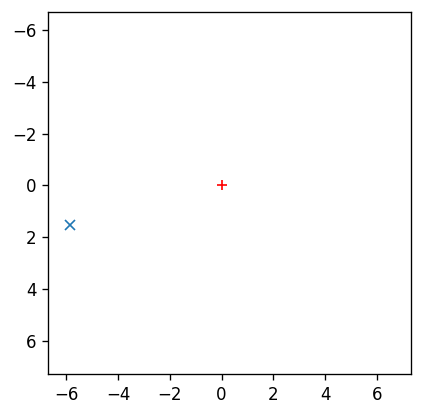

In [441]:
plt.plot( -5.843229, 1.516228 , 'x')
setplot(xc=0, yc=0, rmax=7)
np.hypot(1914.7188293495503 -xc, 996.130338534462-yc)

In [408]:
xylib.calc_movetables(-h,R1['4852'], R2['4852'],-1.9365644998636782, 3.804689281718474, 1.937, 3.804689281718474)

[['ccw', 'theta', 53.95961336]]

In [442]:
1914.817491531154 *pix2mm -xc*pix2mm , 996.2355664196617*pix2mm - yc*pix2mm
angle_between((0,0), (-6,0), ( -5.843229, 1.516228 ))

14.54655287953388

In [439]:
xx1 = 3.0747
xx2 = 2.9625
xxc = 0.10008250469927019
print(xx1**2 + xx2**2 - xxc**2,  2* xx1*xx2, (xx1**2 + xx2**2 - xxc**2)/(2* xx1*xx2))
(xx1/xx2 + xx2/xx1 - (xxc/xx1)*(xxc/xx2) )/2, (xx1/xx2 + xx2/xx1)/2, -(xxc/xx1)*(xxc/xx2)/2 

18.22016983225312 18.2175975 1.000141200410928


(1.000141200410928, 1.0006910263551492, -0.0005498259442212091)

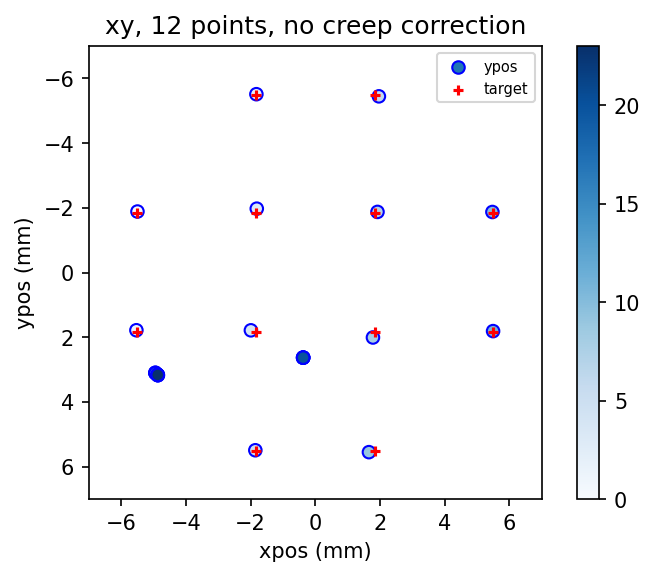

In [746]:
import pandas as pd
db = pd.read_csv("../output/database.csv")
get_timecol(db)

dbxy = db[['xpix','ypix']][db["label"].str.contains('xy12')].reindex()
dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xcmm
dbxy['ypos'] = dbxy["ypix"].values * pix2mm -ycmm
dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)

xy12 = pd.read_csv("../movetables/XY_12.txt", sep=" ", header=None)
xy12.columns = ['xpos', 'ypos']

plt.scatter('xpos', 'ypos', data=dbxy, c=dbxy.index, cmap='Blues', edgecolors='b')
plt.colorbar()
plt.scatter('xpos', 'ypos', data=xy12, c='r', marker='+', s=20, label='target')
plt.title(r"xy, 12 points, no creep correction")
plt.xlim(-7, +7)
plt.ylim(+7, -7)
plt.xlabel('xpos (mm)')
plt.ylabel('ypos (mm)')
plt.gca().set_aspect('equal')
plt.legend(loc='best', fontsize=7)

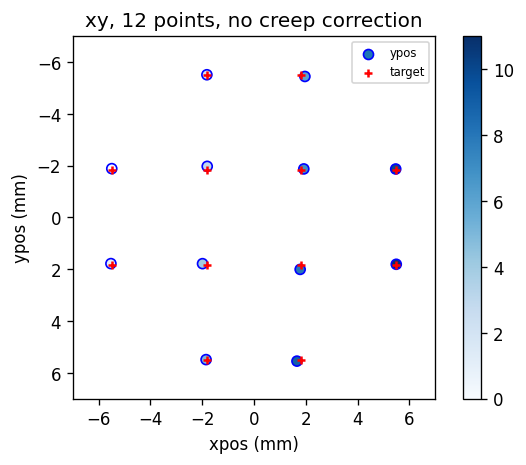

In [571]:
plt.scatter('xpos', 'ypos', data=dbxy, c=dbxy.index, cmap='Blues', edgecolors='b')
plt.colorbar()
plt.scatter('xpos', 'ypos', data=xy12, c='r', marker='+', s=20, label='target')
plt.title(r"xy, 12 points, no creep correction")
plt.xlim(-7, +7)
plt.ylim(+7, -7)
plt.xlabel('xpos (mm)')
plt.ylabel('ypos (mm)')
plt.gca().set_aspect('equal')
plt.legend(loc='best', fontsize=7)

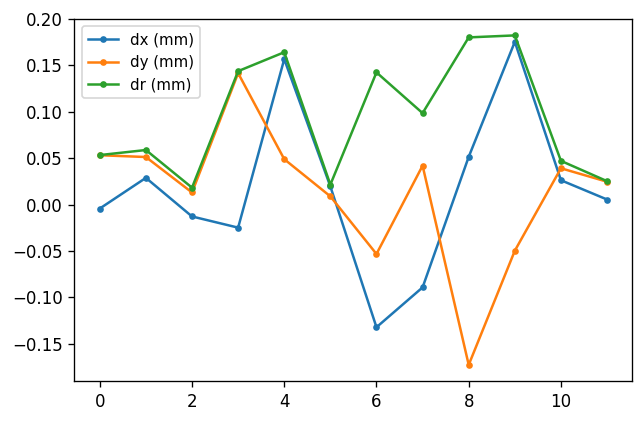

In [552]:
dx, dy = xy12.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx, '.-', label='dx (mm)')
plt.plot(dy, '.-', label='dy (mm)')
plt.plot(dr, '.-', label='dr (mm)')
plt.legend(loc='best', fontsize=9)

Text(0.5, 0, 'r_pos')

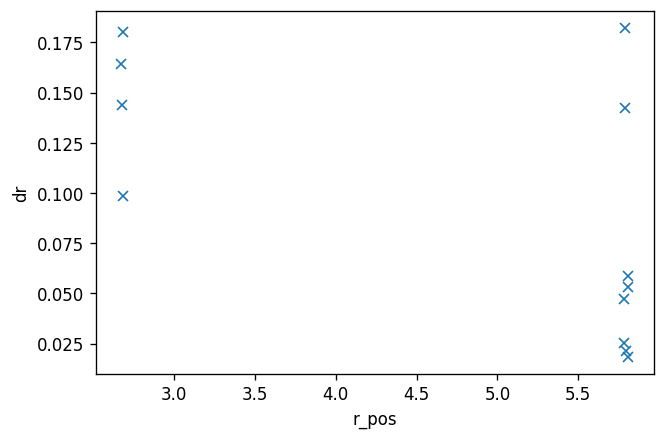

In [568]:
plt.plot(rpos, dr, 'x')

# plt.plot(rpos, dr/rpos, '.')
plt.ylabel('dr')
plt.xlabel('r_pos')


(array([3., 1., 2., 0., 1., 0., 0., 2., 1., 2.]),
 array([0.01826638, 0.0346668 , 0.05106723, 0.06746765, 0.08386807,
        0.1002685 , 0.11666892, 0.13306934, 0.14946977, 0.16587019,
        0.18227061]),
 [<matplotlib.patches.Polygon at 0x7f42214eddd8>])

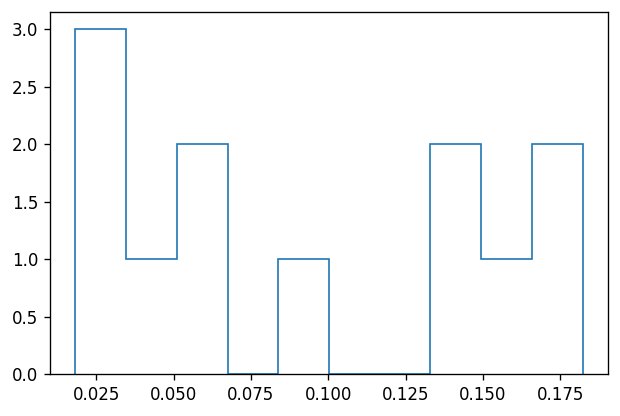

In [489]:
plt.hist(np.hypot(dx,dy), histtype='step')

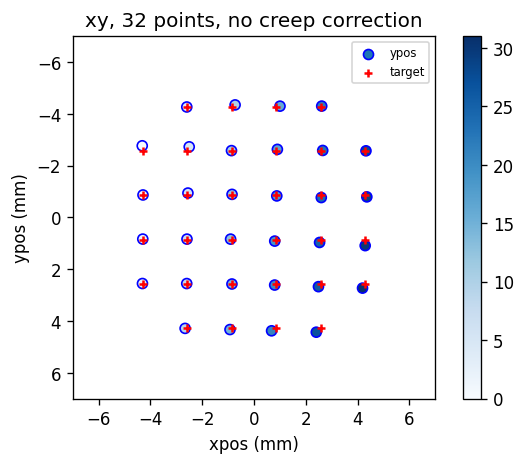

In [573]:
db = pd.read_csv("../output/database.csv")
get_timecol(db)

label = 'xy32'

dbxy = db[['xpix','ypix']][db["label"].str.contains(label)].reindex()
dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xcmm
dbxy['ypos'] = dbxy["ypix"].values * pix2mm -ycmm
dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)

xytgt = pd.read_csv("../movetables/XY_32.txt", sep=" ", header=None)
xytgt.columns = ['xpos', 'ypos']

plt.scatter('xpos', 'ypos', data=dbxy, c=dbxy.index, cmap='Blues', edgecolors='b')
plt.colorbar()
plt.scatter('xpos', 'ypos', data=xytgt, c='r', marker='+', s=20, label='target')
plt.title(r"xy, 32 points, no creep correction")
plt.xlim(-7, +7)
plt.ylim(+7, -7)
plt.xlabel('xpos (mm)')
plt.ylabel('ypos (mm)')
plt.gca().set_aspect('equal')
plt.legend(loc='best', fontsize=7)

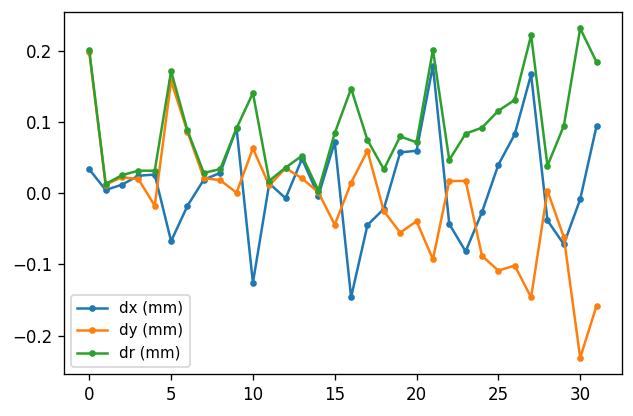

(array([4., 8., 2., 8., 1., 1., 2., 2., 2., 2.]),
 array([0.00377231, 0.02653635, 0.04930039, 0.07206443, 0.09482846,
        0.1175925 , 0.14035654, 0.16312058, 0.18588462, 0.20864866,
        0.2314127 ]),
 [<matplotlib.patches.Polygon at 0x7f421d210da0>])

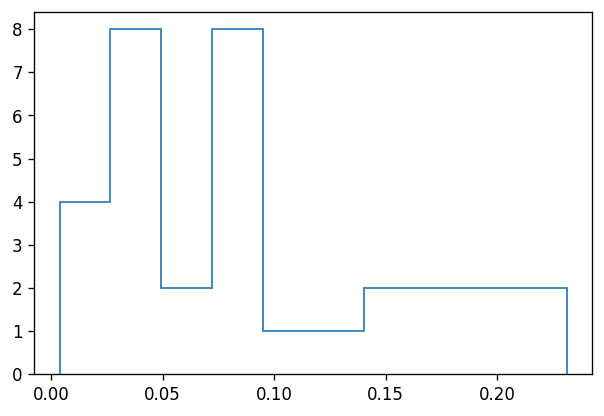

In [575]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx, '.-', label='dx (mm)')
plt.plot(dy, '.-', label='dy (mm)')
plt.plot(dr, '.-', label='dr (mm)')
plt.legend(loc='best', fontsize=9)
plt.show()
plt.hist(np.hypot(dx,dy), histtype='step')

Text(0.5, 0, 'r_pos')

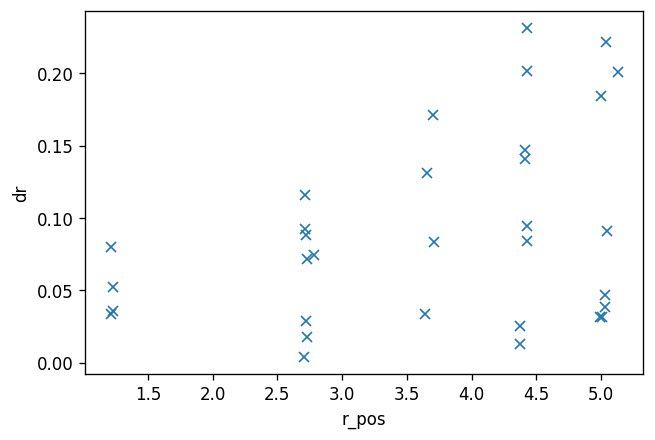

In [576]:
plt.plot(rpos, dr, 'x')

# plt.plot(rpos, dr/rpos, '.')
plt.ylabel('dr')
plt.xlabel('r_pos')


166.74324285319202

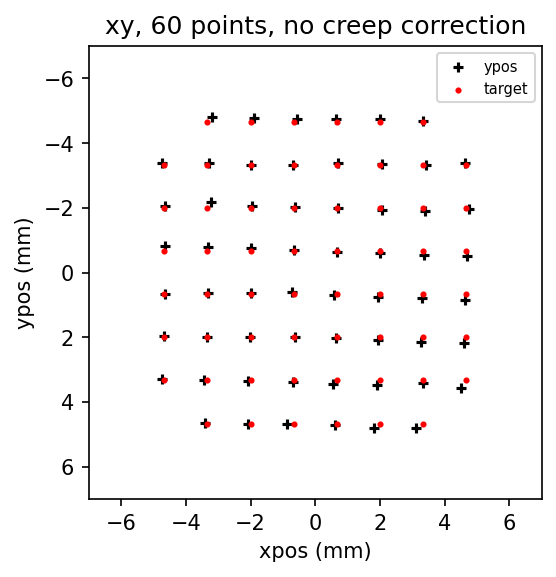

In [668]:
db = pd.read_csv("../output/database.csv")
get_timecol(db)

label = 'xy60'

dbxy = db[['xpix','ypix']][db["label"].str.contains(label)].reindex()
dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xcmm
dbxy['ypos'] = dbxy["ypix"].values * pix2mm -ycmm
dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)

xytgt = pd.read_csv("../movetables/XY_60.txt", sep=" ", header=None)
xytgt.columns = ['xpos', 'ypos']

plt.scatter('xpos', 'ypos', data=dbxy, c='k', marker ='+', s=20)#c=dbxy.index,cmap='Blues', edgecolors='b')
# plt.colorbar()
plt.scatter('xpos', 'ypos', data=xytgt, c='r', marker='.', s=15, label='target')
plt.title(r"xy, 60 points, no creep correction")
plt.xlim(-7, +7)
plt.ylim(+7, -7)
plt.xlabel('xpos (mm)')
plt.ylabel('ypos (mm)')
plt.gca().set_aspect('equal')
plt.legend(loc='best', fontsize=7)
angle_between((0,0), (6, 0), (-5.90, 1.39))

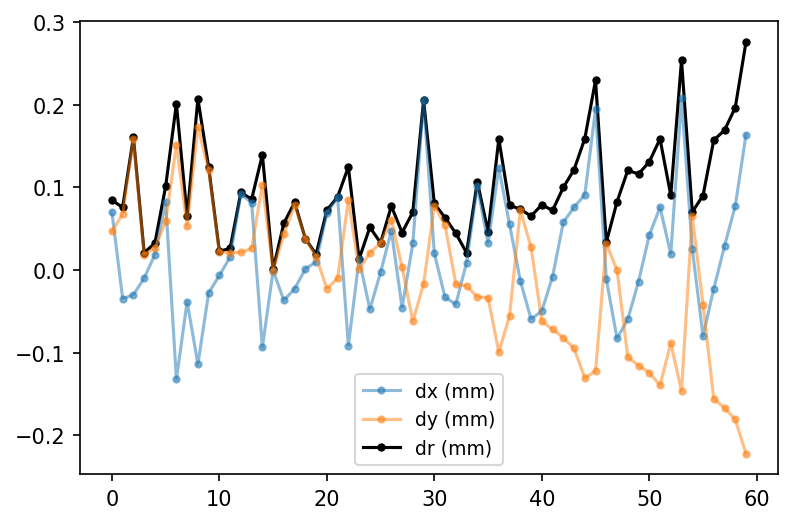

Text(0.5, 0, '$\\delta r \\;(mm)$')

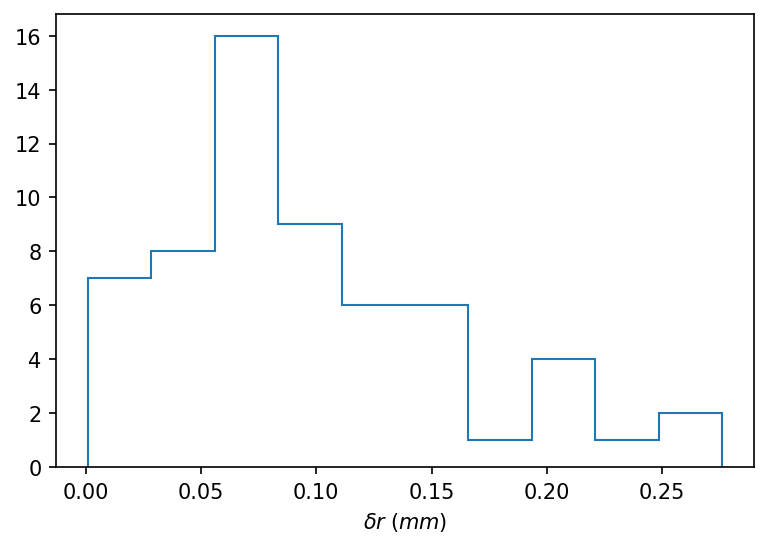

In [657]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()
plt.hist(np.hypot(dx,dy), histtype='step')
plt.xlabel('$\delta r \;(mm)$')

In [685]:
def plot_dxy(petal_loc, xptl1, yptl1, xptl2, yptl2, scale=5, ref=200, 
             isFP=False, returnuv=False, ax = None, title=None):
    """
    petal_loc dim(5000)
    xptl dim(5000)
    scale (for plot)
    ref (for plot)
    dx, dy, dalpha len = 10
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=130)
    if title is not None: ax.set_title(title)
    
    ax.axis('off')
    ax.set_aspect(1)
    dx, dy, dalpha = np.zeros((3, 10))
    if isFP:
        xfp1, yfp1 = xptl1, yptl1
        xfp2, yfp2 = xptl2, yptl2
    if not isFP:
        xfp1, yfp1 = ptl2fp(petal_loc, xptl1, yptl1, dx, dy, dalpha)
        xfp2, yfp2 = ptl2fp(petal_loc, xptl2, yptl2, dx, dy, dalpha)
#     pdb.set_trace()
    # Calculate residuals in microns.
    u = 1e3 * (xfp2 - xfp1)
    v = 1e3 * (yfp2 - yfp1)
    dr = np.hypot(u, v)
    print(f'Max arrow length = {np.max(dr):.1f} um')
    Q = ax.quiver(xfp1, yfp1, u, v, dr, angles='xy', scale=scale, scale_units='xy',
                  headwidth=8, headlength=9, width=0.001, cmap='plasma_r')
    ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
    
    if returnuv:
        return u,v

TypeError: _histogram_dispatcher() missing 1 required positional argument: 'a'

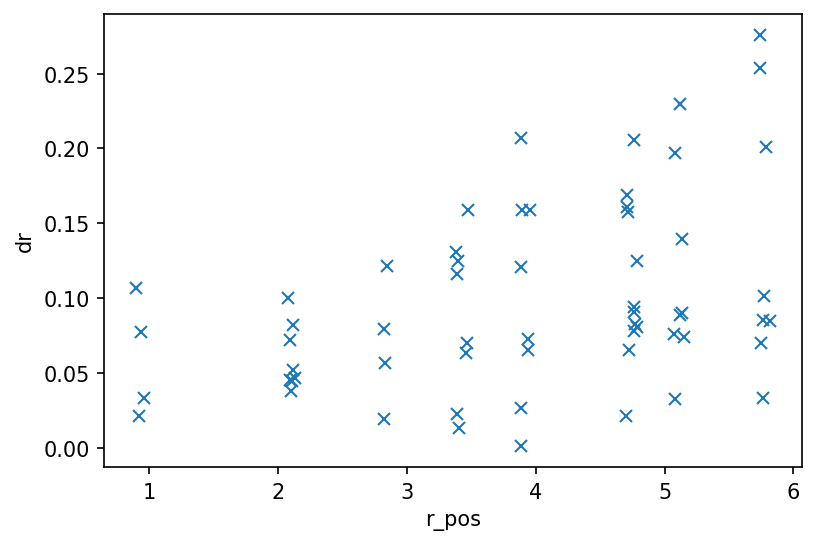

In [594]:

plt.plot(rpos, dr, 'x')

# plt.plot(rpos, dr/rpos, '.')
plt.ylabel('dr')
plt.xlabel('r_pos')

np.histogram(dr)

In [616]:
ibins = np.digitize(rpos, rbins)
dr[ibins==1]

array([0.03303996, 0.07748403, 0.02102218, 0.10701075])

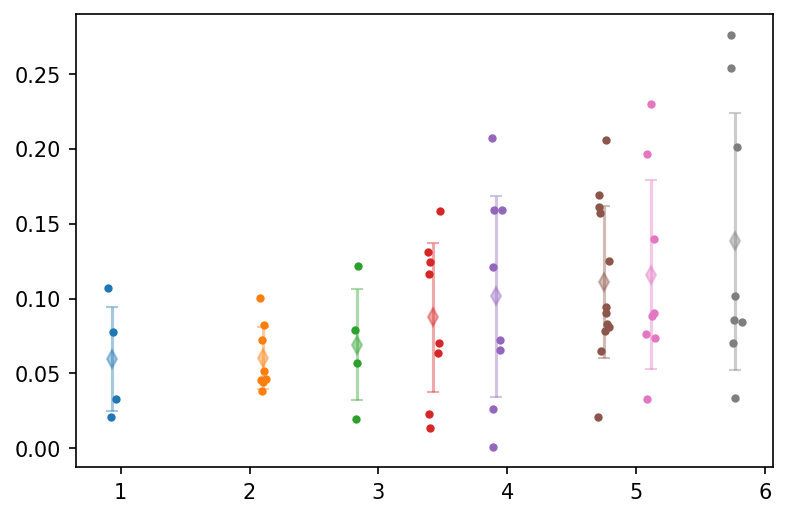

In [647]:
rbinned = []
for i in set(ibins):
    _dr =  dr[ibins==i]
    _rpos = rpos[ibins==i]
    rbinned.append(np.array(_dr))
    p = plt.plot(_rpos,_dr, '.')
    plt.errorbar(_rpos.mean(), _dr.mean(), yerr=_dr.std(), capsize=3, fmt='d', c=p[0].get_color(), 
                 alpha=0.4,zorder=0)

Max arrow length = 276.0 um


Text(0, 0.5, 'y')

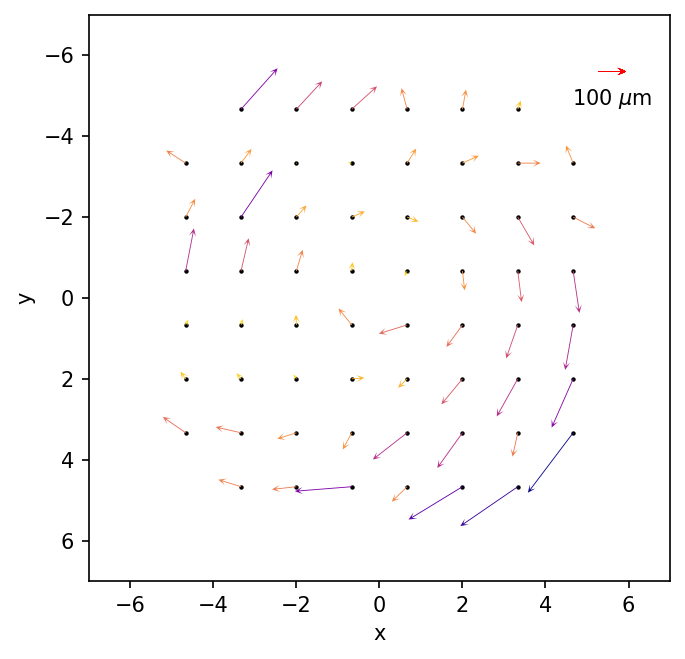

In [745]:
# Creating plot
fig, ax = plt.subplots(figsize = (5, 5))

label = 'xy60'
xpos = dbxy['xpos'].values
ypos = dbxy['ypos'].values
xt = xytgt['xpos'].values
yt = xytgt['ypos'].values

# Calculate residuals in microns.
u = 1e3 * (xpos - xt)
v = 1e3 * (ypos - yt)
dr = np.hypot(u, v)
print(f'Max arrow length = {np.max(dr):.1f} um')

ref=100
ax.scatter(xt, yt, marker='.', c='k', s=5)
Q = ax.quiver(xt, yt, u, v, dr, angles='xy', scale=150, scale_units='xy',
              headwidth=8, headlength=9, width=0.001*1.5, color='r' ,cmap='plasma_r')

ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
ax.set_xlim(-7,7)
ax.set_ylim(7,-7)
ax.set_xlabel('x')
ax.set_ylabel('y')


In [759]:
angle_between((0,0), (6,0), (  -5.884947, 1.430235   ) )

166.34007872386528

In [756]:
xylib.calc_movetables( -166.27, 3.079, 2.966, -2.029635, 3.817421, 3.0747, -2.9625)

[['ccw', 'theta', 161.1824366], ['ccw', 'phi', 1.44919272]]

In [ ]:
xylib.calc_moves()